# Generate Historical Data
M.J. Madsen
2017-07-06

This notebook generates a set of historical interactions between clients and resources. 

## "Hidden" Matrices

The outcomes of the interactions between the clients and resources are based on two "hidden" sets of data:
1. The skill sets of the resources for each condition
2. The familiarity between each resource and client

The clients have a probability of having each condition. Based on the conditions, resources, skills, and familiarity, a trinary outcome is generated leaning slightly towards a positive outcome.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set the scope of the data
n_resources = 20 
n_conditions = 20
n_clients = 20

conditionskillrank = 5 #Number of divisions in the (normalized) skills matrix
familiarityrank = 3 #Scale of familiarity: 0 = no familiarity, 2 = very familiar

In [3]:
np.random.seed(42)

# Build resource skill data for each condition
skillmat = np.random.randint(conditionskillrank, size=[n_resources,n_conditions])/conditionskillrank
resource_df = pd.DataFrame(skillmat)
resource_df.columns = ['CondID_' + str(item) for item in  resource_df.columns]
resource_df['ResourceID'] = range(len(resource_df))
resource_df.to_csv('../data/resource_skills.csv',index=False)

# Build resource/client familiarity data
fammat = np.random.randint(familiarityrank, size=[n_resources,n_clients]) + 1 # if this is 1 there is no familiarity modifier
resource_client_df = pd.DataFrame(fammat)
resource_client_df.columns = ['clientID_' + str(item) for item in  resource_client_df.columns]
resource_client_df['ResourceID'] = range(len(resource_client_df))
resource_client_df.to_csv('../data/familiarity.csv',index=False)

# chronic conditions for clients - probability of each condition arising
client_condition_matrix = np.random.beta(2,8,size=[n_clients,n_conditions])
client_condition_df = pd.DataFrame(client_condition_matrix)
client_condition_df.columns = ['Cond_' + str(item) for item in  client_condition_df.columns]
client_condition_df['ClientID'] = range(len(client_condition_df))
client_condition_df.to_csv('../data/client_conditions.csv',index=False)

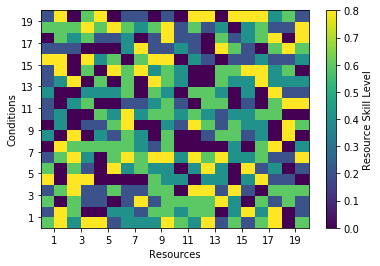

In [4]:
plt.pcolor(skillmat)
plt.colorbar(label="Resource Skill Level")
plt.xlabel('Resources')
plt.ylabel('Conditions')
plt.xticks(range(1,n_resources,2))
plt.yticks(range(1,n_conditions,2))
plt.show()

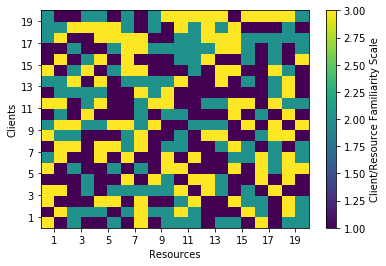

In [5]:
plt.pcolor(fammat)
plt.colorbar(label="Client/Resource Familiarity Scale")
plt.xlabel('Resources')
plt.ylabel('Clients')
plt.xticks(range(1,n_resources,2))
plt.yticks(range(1,n_clients,2))
plt.show()

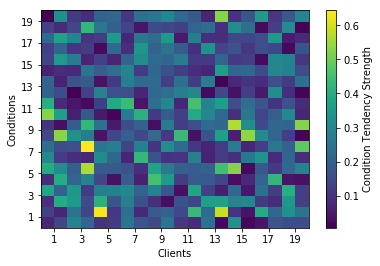

In [6]:
plt.pcolor(client_condition_matrix)
plt.colorbar(label="Condition Tendency Strength")
plt.xlabel('Clients')
plt.ylabel('Conditions')
plt.xticks(range(1,n_clients,2))
plt.yticks(range(1,n_conditions,2))
plt.show()

## Simulate Interactions

I now simulate the interactions between clients and resouces. The proceedure is:

1. Choose which condition and which resource to use
2. Because each interaction is unique, generate a unique set of conditions for this interaction, guaranteeing that there is at least one condition (otherwise there would be no need for an interaction). The probability of any condition happening is based on the `client_condition_matrix`. 
3. Scale the conditions based on a random number between 0 and 1.
4. Take the dot product of the resource skill matrix (for the chosen resource) and the condition vector. A larger skill for a given condition increases the overall scale of the dot product.
5. Take the natural log of this number (if it is positive): this scales the interaction size better.
6. Add the level of client/resource familiarity to the outcome
7. Slice the outcome based on the `outcomebins`. This was chosen to give a slightly positive-skewed distribution.

In [7]:
n_outcomes = 100000

outcomes = np.zeros((n_outcomes,3+n_conditions))

def getOutcome(resourceID, clientID, condmat):
    outcomebins = [-0.1,1.5,100]
    
    skillcondmatch = np.dot(skillmat[resourceID],condmat) #bigger is a better match
    if skillcondmatch > 0:
        skillcondmatch = np.log(skillcondmatch)
    familiarity = fammat[resourceID,clientID] # bigger is more familiar
    
    raw_outcome = (skillcondmatch + familiarity)
    outcome = np.digitize(raw_outcome,outcomebins)-1
    return outcome

for resp in range(n_outcomes):

    # Choose Client and Resource
    clientID = np.random.randint(n_clients)
    resourceID = np.random.randint(n_resources)

    # Build the condition vector
    condmat = np.array([1] + list(np.zeros(n_conditions-1))) # Make sure there is at least one condition
    np.random.shuffle(condmat) # Randomize its location
    # Add in other conditions based on the client characteristics
    condmat = np.clip(condmat + np.greater(np.random.random(n_conditions),1-client_condition_matrix[clientID]),0,1)
    condmat *= np.random.beta(2,4,size=n_conditions) # Scale the size of the conditions as a random number, beta distributed.

    outcomes[resp] = list([clientID, resourceID, getOutcome(resourceID,clientID,condmat)]) + list( condmat)
    if resp % int(n_outcomes/10) == 0:
        print("Progress: {:0.0f}%".format(100*resp/n_outcomes + 10 ))

Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


## Outcome Exploration
I now look at what I've got in terms of outcomes, looking at a variety of metrics.

The distribution of (non-zero) conditions.

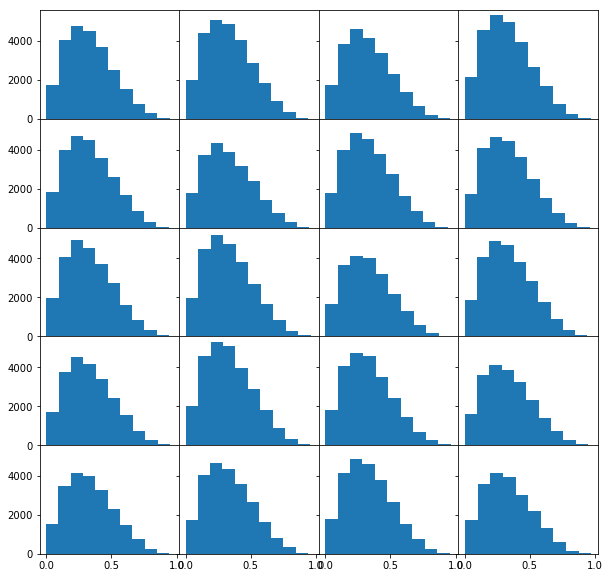

In [8]:
outcomes_df = pd.DataFrame(outcomes, columns=['clientID','resourceID','outcome'] + ['Cond_' + str(i) for i in range(n_conditions)])
f, axarr = plt.subplots(int(n_conditions/4),int(n_conditions/5), figsize=[10,10],sharex=True,sharey=True)
thiscond = 0
for ax in axarr:
    for subax in ax:
        conditions = outcomes_df[outcomes_df.columns[outcomes_df.columns=='Cond_{}'.format(thiscond)]].values
        subax.hist(conditions[conditions > 0])
        thiscond += 1
f.subplots_adjust(wspace=0, hspace=0)

The client-resource outcomes for a sample of 5 clients and 5 resources.

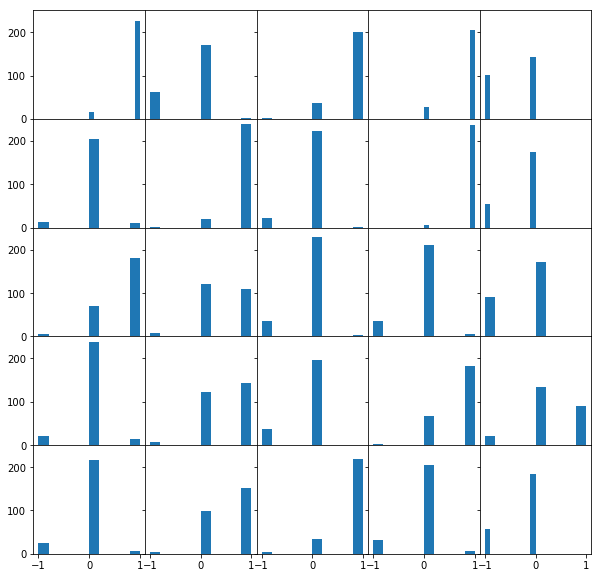

In [9]:
f, axarr = plt.subplots(5, 5, figsize=[10,10],sharex=True,sharey=True)
for name,group in outcomes_df.groupby(['clientID','resourceID']):
    if (name[0] < 5) and (name[1] < 5):
        axarr[int(name[0]),int(name[1])].hist(group['outcome'])
f.subplots_adjust(wspace=0, hspace=0)

Looking at a rolling average of the outcomes, assuming that the data were taken in order.

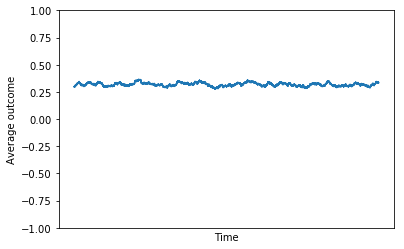

In [10]:
outcome_rollmean = (outcomes_df['outcome'].rolling(2000).mean())

plt.plot(outcome_rollmean)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Average outcome')
plt.ylim(-1,1)
plt.show()
#plt.savefig("../docs/ml_kpi_plot.png")

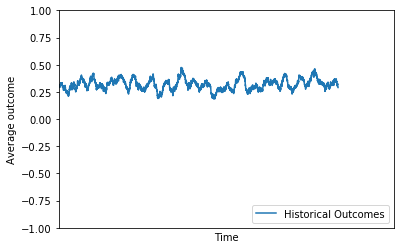

In [34]:
outcome_rollmean_small = (outcomes_df['outcome'].rolling(200).mean())

priorpoints = 10000
plt.plot(np.arange(priorpoints),outcome_rollmean_small.values[-priorpoints:],label="Historical Outcomes")
plt.xlim(0,priorpoints + 2000)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Average outcome')
plt.ylim(-1,1)
plt.legend(loc='lower right')

plt.savefig("../docs/train_sub_rolling_average.png",dpi=300)
plt.show()

## Save Data

In [23]:
outcomes_df['clientID'] = outcomes_df['clientID'].astype(int)
outcomes_df['resourceID'] = outcomes_df['resourceID'].astype(int)
outcomes_df['outcome'] = outcomes_df['outcome'].astype(int)
outcomes_df.to_csv('../data/train_outcomes.csv',index=False, float_format='%.2f')

# Testing Data

The next step is to generate the testing data - 10000 events times 5 possible resource combinations per event. This will let us check the predictions against "actual" outcomes for 10000 events.

In [24]:
test_outcomes = 10000
n_per_resource = 5

outcomes = np.zeros((test_outcomes*5,3+n_conditions+1))

for resp in range(test_outcomes):

    # Selet the Client
    clientID = np.random.randint(n_clients)

    # Build the Client condition vector
    condmat = np.array([1] + list(np.zeros(n_conditions-1)))
    np.random.shuffle(condmat)
    condmat = np.clip(condmat + np.greater(np.random.random(n_conditions),1-client_condition_matrix[clientID]),0,1)*np.random.beta(2,4,size=n_conditions)

    
    # Build the resource - there will be 5 possibilities here
    rescomb = np.arange(n_resources)
    np.random.shuffle(rescomb)
    resourceCombos = rescomb[:n_per_resource]
    for k in range(n_per_resource):
        resourceID = resourceCombos[k]
        outcomes[resp * n_per_resource + k] = list([resp]) + list([clientID, resourceID, getOutcome(resourceID,clientID,condmat)]) + list( condmat)
            
    if resp % int(test_outcomes/10) == 0:
        print("Progress: {:0.0f}%".format(100*resp/test_outcomes + 10 ))  

Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


In [25]:
tdf = pd.DataFrame(outcomes, columns=['interactionID','clientID','resourceID','outcome'] + ['Cond_' + str(i) for i in range(n_conditions)])
tdf['interactionID'] = tdf['interactionID'].astype(int)
tdf['clientID'] = tdf['clientID'].astype(int)
tdf['resourceID'] = tdf['resourceID'].astype(int)
tdf['outcome'] = tdf['outcome'].astype(int)
tdf.to_csv('../data/test_outcomes.csv',index=False, float_format='%.2f')

If we choose the first resource in each interaction, what would the outcomes look like?

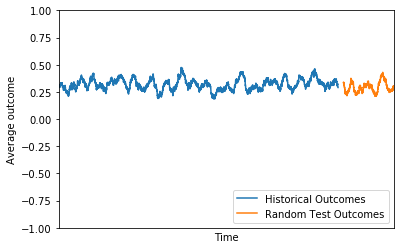

In [35]:
test_rollmean = (tdf['outcome'].loc[range(0,test_outcomes,5)].rolling(200).mean())
outcome_rollmean_small = (outcomes_df['outcome'].rolling(200).mean())

priorpoints = 10000
plt.plot(np.arange(priorpoints),outcome_rollmean_small.values[-priorpoints:],label="Historical Outcomes")
plt.plot(np.arange(len(test_rollmean))+priorpoints,test_rollmean.values,label="Random Test Outcomes")
plt.xticks([])
plt.xlim(0,priorpoints + 2000)
plt.xlabel('Time')
plt.ylabel('Average outcome')
plt.ylim(-1,1)
plt.legend(loc='lower right')

plt.savefig("../docs/train_test_rolling_average.png",dpi=300)
plt.show()